## Directional Distance Function Experiments
This notebooks contains experiments in using a directional distance field for visibility in RENI-NeuS

In [ ]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")


import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import get_directions, get_sineweight, look_at_target, random_points_on_unit_sphere
from reni_neus.illumination_fields.reni_field import RENIField
from reni_neus.data.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.data.ddf_datamanager import DDFDataManagerConfig, DDFDataManager
from reni_neus.reni_neus_config import RENINeuS as RENINeuSMethodSpecification, DirectionalDistanceField  

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = '/workspace/outputs/unnamed/ddf/2023-06-20_085448'
step = 20000

ckpt = torch.load(ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
vision_model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        vision_model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)

pipeline = config.pipeline.setup(device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank)

# now we need to load reni and ddf model
reni_neus_ckpt_path = '/workspace/outputs/unnamed/reni-neus/2023-06-07_141907/' # model without vis
step = 85000

ckpt = torch.load(reni_neus_ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
reni_neus_model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        reni_neus_model_dict[key[7:]] = ckpt['pipeline'][key]

pipeline.model.load_state_dict(vision_model_dict)
pipeline.reni_neus.load_state_dict(reni_neus_model_dict)
pipeline.model.eval()
pipeline.reni_neus.eval()

print('Model loaded')

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 5 images.

Output()

Model loaded


In [34]:
idx = 4
batch = pipeline.datamanager.eval_dataset[(idx)]
ray_bundle = batch['ray_bundle']
# change camera_indices to int of 3's of the same size
ray_bundle.camera_indices = (torch.ones_like(ray_bundle.camera_indices) * idx).type(torch.int64)
ddf_output = pipeline.model.get_outputs_for_camera_ray_bundle(ray_bundle, reni_neus=None, show_progress=True)
ddf_output['expected_termination_dist'].max(), batch['termination_dist'].max()

Output()

(tensor(1.8304), tensor(2.))

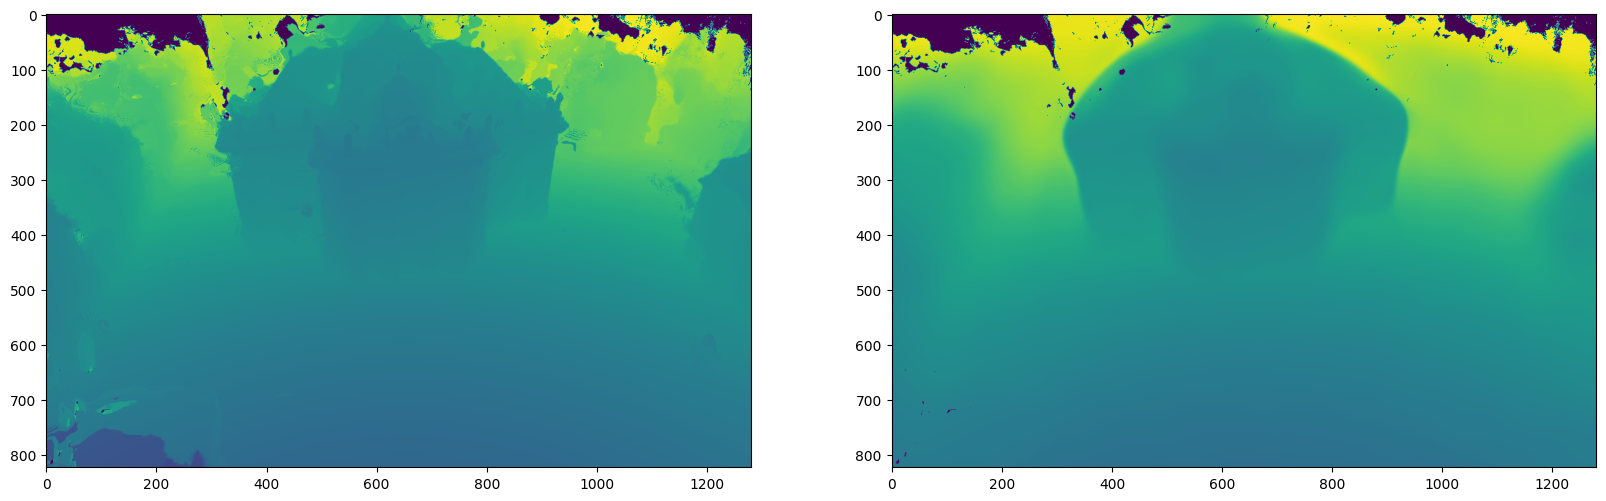

In [20]:
# plot reni_output['ptp_dist'] and ddf_output['expected_termination_dist'] side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow((batch['termination_dist'] * batch['mask']).cpu().detach().numpy())
plt.subplot(1, 2, 2)
plt.imshow((ddf_output['expected_termination_dist'] * batch['mask']).cpu().detach().numpy())
plt.show()

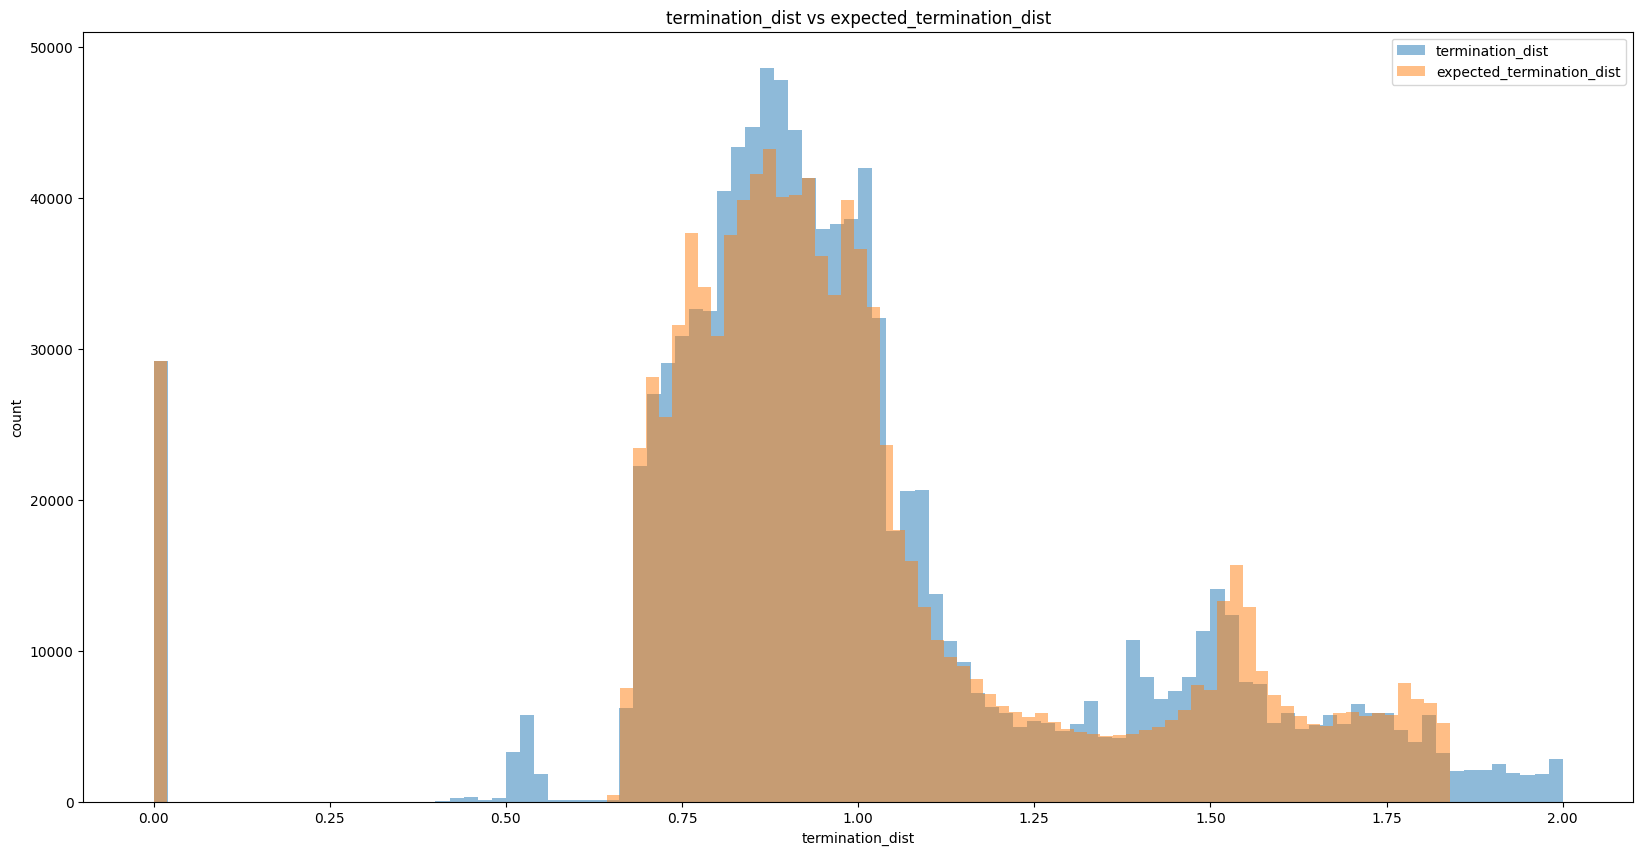

In [23]:
# # plot a histogram for both images, include titles and axis labels
# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.hist((batch['termination_dist'] * batch['mask']).cpu().detach().numpy().flatten(), bins=100)
# plt.title('termination_dist')
# plt.xlabel('termination_dist')
# plt.ylabel('count')
# plt.subplot(1, 2, 2)
# plt.hist((ddf_output['expected_termination_dist'] * batch['mask']).cpu().detach().numpy().flatten(), bins=100)
# plt.title('expected_termination_dist')
# plt.xlabel('expected_termination_dist')
# plt.ylabel('count')
# plt.show()

# overlay histograms
plt.figure(figsize=(20, 10))
plt.hist((batch['termination_dist'] * batch['mask']).cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='termination_dist')
plt.hist((ddf_output['expected_termination_dist'] * batch['mask']).cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='expected_termination_dist')
plt.title('termination_dist vs expected_termination_dist')
plt.xlabel('termination_dist')
plt.ylabel('count')
plt.legend()
plt.show()


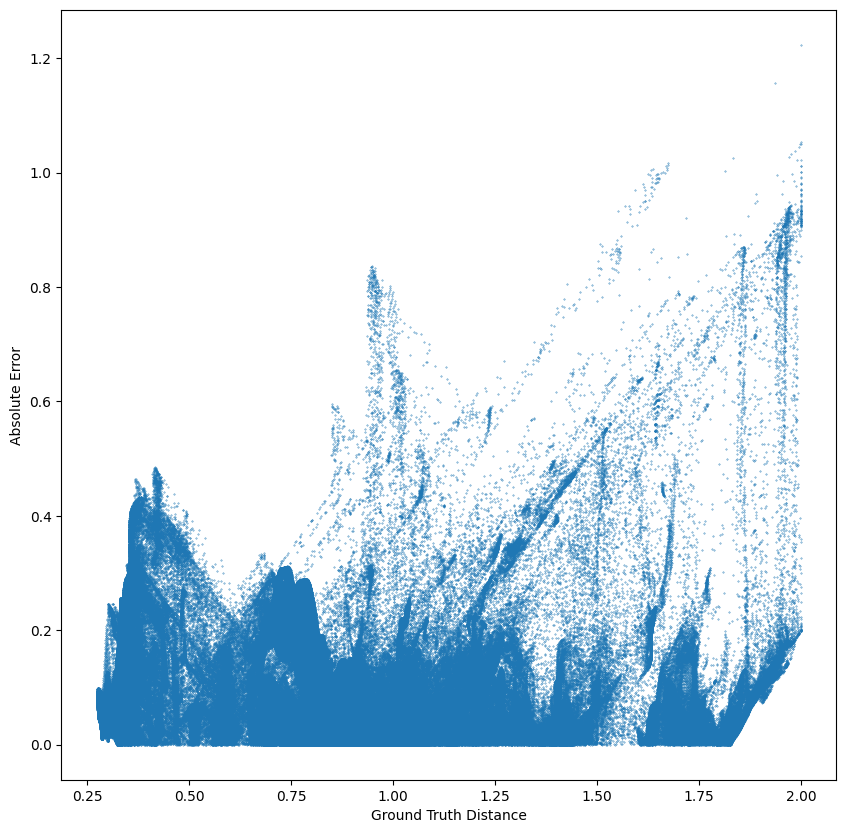

In [13]:
# create scatter plot of predicted distance vs relative error
# get predicted distance
# first mask both by accumulation
mask = reni_output['accumulation'] > 0.7
mask = mask.cpu().detach().numpy()
predicted_distances = ddf_output['expected_termination_dist'].cpu().detach().numpy()
# get ground truth distance
ground_truth_distances = reni_output['p2p_dist'].cpu().detach().numpy()
# mask both by ground truth
predicted_distances = predicted_distances[mask].flatten()
ground_truth_distances = ground_truth_distances[mask].flatten()
# clamp ground_truth between 0 and 2
ground_truth_distances = np.clip(ground_truth_distances, 0, 2)
# get relative error
relative_error = np.abs(predicted_distances - ground_truth_distances) / ground_truth_distances
# absolute error
absolute_error = np.abs(predicted_distances - ground_truth_distances)
# create scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(ground_truth_distances, absolute_error, s=0.1)
plt.xlabel('Ground Truth Distance')
plt.ylabel('Absolute Error')
plt.show()

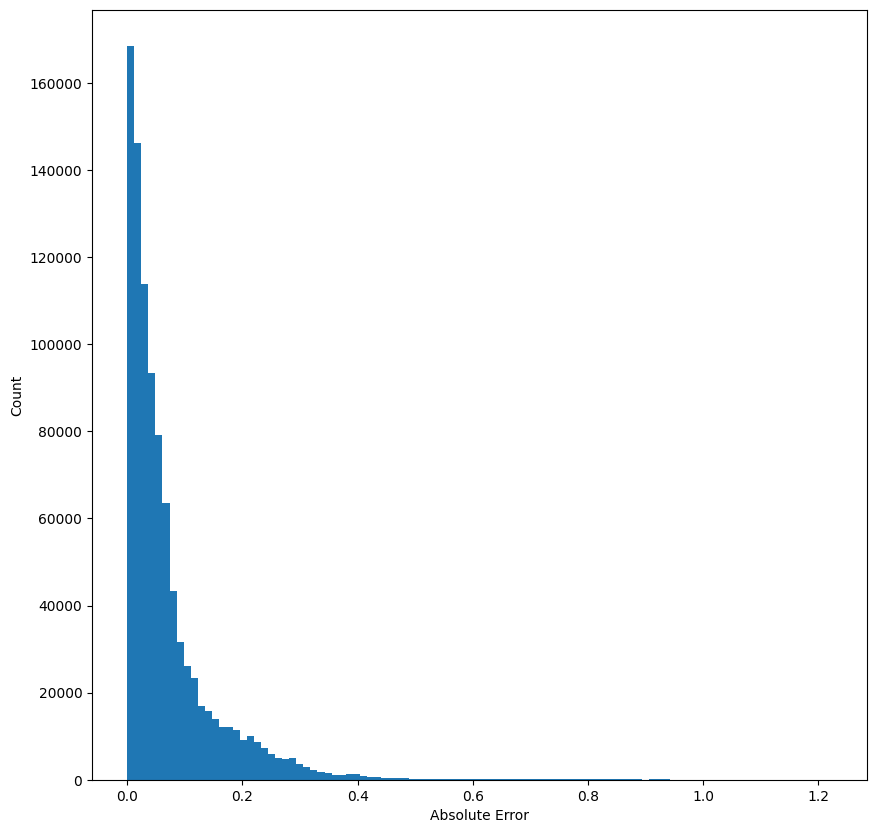

In [15]:
# create a histogram of the errors
plt.figure(figsize=(10, 10))
plt.hist(absolute_error, bins=100)
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.show()

In [17]:
# calculate % of errors below 0.2
print(f'Percentage of errors below 0.2: {np.sum(absolute_error < 0.2) / absolute_error.shape[0] * 100}%')
# below 0.1
print(f'Percentage of errors below 0.1: {np.sum(absolute_error < 0.1) / absolute_error.shape[0] * 100}%')

Percentage of errors below 0.2: 91.8278306966131%
Percentage of errors below 0.1: 78.210314988176%


In [ ]:
pipeline.reni_neus.config.visibility_field = True
pipeline.reni_neus.visibility_field = pipeline.model
pipeline.reni_neus.config.only_upperhemisphere_visibility = True
pipeline.reni_neus.visibility_threshold = 0.2
reni_output = pipeline.reni_neus.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True)